In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [13]:
Npix = 100
Nmax = 5
wavelength = 1
umax = 10000
freq = 1
c = 1
ep_o = 1
mu_o = 1

dx = dy = dz = wavelength/10
dt = dx/(umax*np.sqrt(3))
R = dt/(2*ep_o)
Ra = (c*dt/dx)**2
Rb = dt/(mu_o*dx)

#Ex = Ey = Ez = Hx = Hy = Hz = np.zeros((Npix,Npix))

sig_types = [1.2,2.3,1.0]
ep_r_types = [1,1,1]
media = np.zeros((Npix,Npix,Npix))
media[:,:,:int(Npix/3)] = 0
media[:,:,int(Npix/3):int(2*Npix/3)] = 1
media[:,:,int(2*Npix/3):] = 2

sigma = sig_types[0]*(media == 0) + sig_types[1]*(media == 1) + sig_types[2]*(media == 2)
ep_r = ep_r_types[0]*(media == 0) + ep_r_types[1]*(media == 1) + ep_r_types[2]*(media == 2)
Ca = (1 - (R*sigma/ep_r))/(1 + (R*sigma/ep_r))
Cb = Ra/(ep_r + R*sigma)
Cb=1
Ca=1

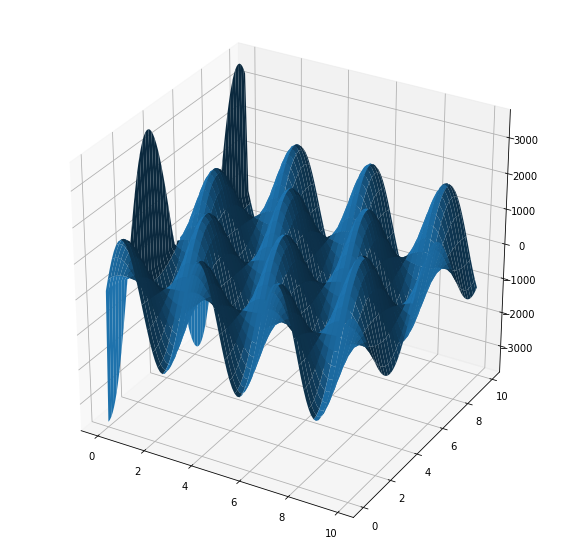

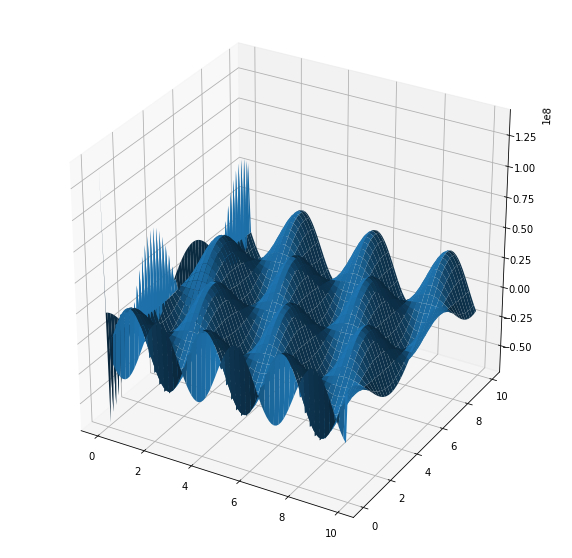

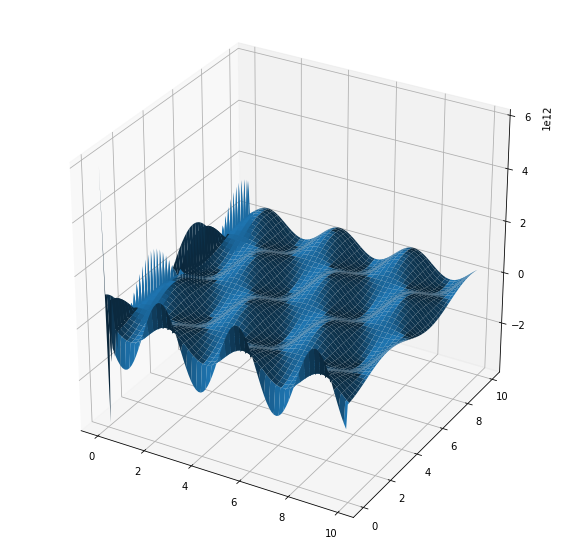

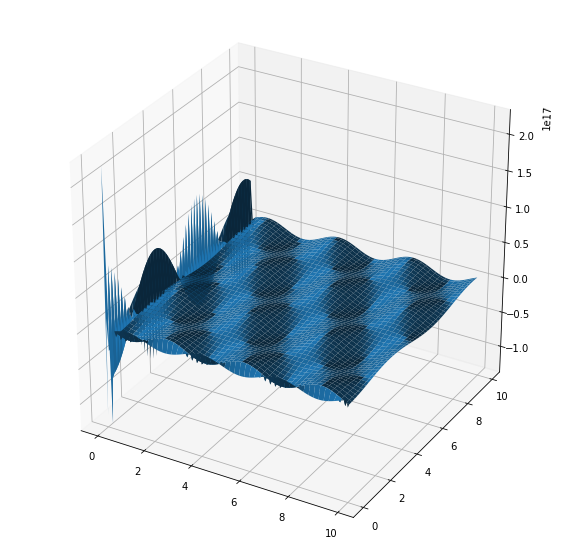

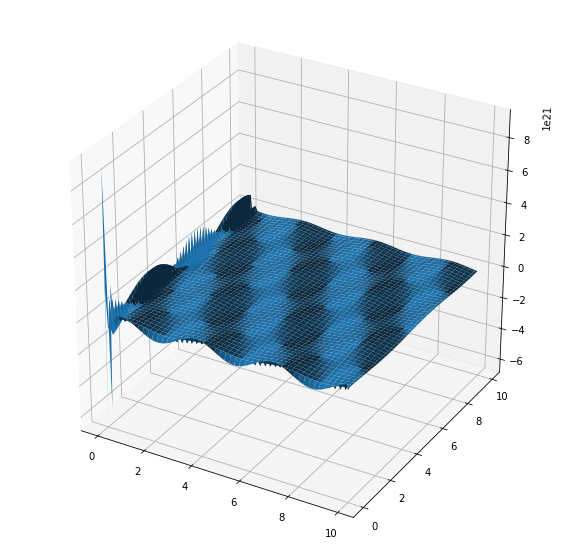

In [14]:
# Initialize
E = H = np.zeros((Npix,Npix,Npix,3))

# initial conditions
x = dx*np.array(range(Npix))
y = dy*np.array(range(Npix))
z = dz*np.array(range(Npix))
x,y = np.array(np.meshgrid(x,y))
E[:,:,int(Npix/2),2] = np.sin(x)*np.cos(y)*np.sin(z)
H[:,:,int(Npix/2),1] = np.sin(x)*np.cos(y)*np.sin(z)


for n in range(Nmax):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    E_temp = H_temp = np.zeros((Npix,Npix,Npix,3))
                     
    H_temp[:,:,:,0] = H[:,:,:,0] + Rb*np.roll(E[:,:,:,1],-1,axis=2) - E[:,:,:,1] - np.roll(E[:,:,:,2],-1,axis=1) + E[:,:,:,2]

    H_temp[:,:,:,1] = H[:,:,:,1] + Rb*np.roll(E[:,:,:,2],-1,axis=0) - E[:,:,:,2] - np.roll(E[:,:,:,0],-1,axis=2) + E[:,:,:,0]

    H_temp[:,:,:,2] = H[:,:,:,2] + Rb*np.roll(E[:,:,:,0],-1,axis=1) - E[:,:,:,0] - np.roll(E[:,:,:,1],-1,axis=0) + E[:,:,:,1]

    E_temp[:,:,:,0] = Ca*E[:,:,:,0] + Cb/Rb*(H[:,:,:,2] - np.roll(H[:,:,:,2],1,axis=1) - H[:,:,:,1] + np.roll(H[:,:,:,1],1,axis=2))

    E_temp[:,:,:,1] = Ca*E[:,:,:,1] + Cb/Rb*(H[:,:,:,0] - np.roll(H[:,:,:,0],1,axis=2) - H[:,:,:,2] + np.roll(H[:,:,:,2],1,axis=0))

    E_temp[:,:,:,2] = Ca*E[:,:,:,2] + Cb/Rb*(H[:,:,:,1] - np.roll(H[:,:,:,1],1,axis=1) - H[:,:,:,0] + np.roll(H[:,:,:,0],1,axis=1))
    
    E=E_temp
    H=H_temp
    
    
    x = dx*np.array(range(Npix))
    y = dy*np.array(range(Npix))
    x,y = np.array(np.meshgrid(x,y))
    z = E[:,:,int(Npix/2),2]
    ax.plot_surface(x,y,z)
plt.savefig("plot.png")
plt.show()

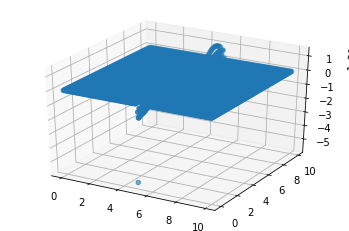

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = dx*np.array(range(Npix))
y = dy*np.array(range(Npix))
x,y = np.array(np.meshgrid(x,y))
z = H[:,2,:,2]
ax.scatter(x,y,z)
plt.show()